# Distracted Driving Detection

## Load the Data

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split

def loadImages(path):
    data = load_files(path)
    files = data['filenames']
    targets = data['target']
    target_names = data['target_names']
    return files, targets, target_names
    
path = "images/train"
files,targets,target_names = loadImages(path)
test_files = np.array(glob("images/test/*"))
print('Number of Categories: ', len(target_names))
print('Categories: ', target_names)
print('Number of images by category: ')
for c in target_names:
    print(c + ':' + str(len( os.listdir(path+'/'+c))))
# train_data = np.vstack((files, targets)).T
# print(train_data.shape)

#Split the original training sets into training & validation sets
train_files, valid_files, train_targets, valid_targets = train_test_split(files, targets, test_size=0.25, random_state=42)

print(train_files.shape, valid_files.shape, train_targets.shape, valid_targets.shape)
print(len(test_files))


Using TensorFlow backend.


Number of Categories:  10
Categories:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Number of images by category: 
c0:1900
c1:1900
c2:1900
c3:1900
c4:1900
c5:1900
c6:1900
c7:1900
c8:1900
c9:1900
(14250,) (4750,) (14250,) (4750,)
79726


# Data Analysis

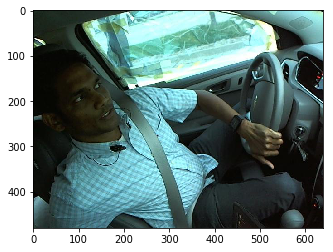

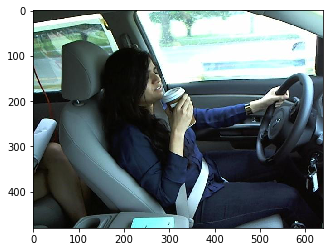

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(1,3):
    sample_image = cv2.imread(train_files[i])
    gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()


In [3]:

#(nb_samples,rows,columns,channels)
#nb_samples - total number of images
# Resize image to 224x224 
# Convert image to an array -> resized to a 4D tensor used by Keras CNN
# Tensor will be (1,224,224,3)

#Adopted from the Deep Learning Project
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


## Pre-Process the Data


In [12]:
#Rescale the images 

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_tensors = paths_to_tensor(train_files[1:20]).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files[1:20]).astype('float32')/255
#test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.40it/s]


## Baseline Model Architecture

In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 221, 221, 10)      490       
_________________________________________________________________
global_average_pooling2d_5 ( (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

In [ ]:
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils

train_targets_onehot = np_utils.to_categorical(np.array(train_targets),10)
valid_targets_onehot = np_utils.to_categorical(np.array(valid_targets),10)
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.

# checkpointer = ModelCheckpoint(filepath='C:/Users/pushkar/ML/machine_learning/projects/capstone/saved_models/weights.best.from_scratch.hdf5', 
#                                 verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets_onehot[1:20], 
          validation_data=(valid_tensors, valid_targets_onehot[1:20]),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 19 samples, validate on 19 samples
Epoch 1/100

Epoch 00001: val_loss did not improve
19/19 [==============================] - 1s 51ms/step - loss: 2.2409 - acc: 0.1579 - val_loss: 2.3887 - val_acc: 0.1579
Epoch 2/100

Epoch 00002: val_loss did not improve
19/19 [==============================] - 1s 45ms/step - loss: 2.2372 - acc: 0.1579 - val_loss: 2.3977 - val_acc: 0.1579
Epoch 3/100

Epoch 00003: val_loss did not improve
19/19 [==============================] - 1s 37ms/step - loss: 2.2340 - acc: 0.1579 - val_loss: 2.4066 - val_acc: 0.1579
Epoch 4/100

Epoch 00004: val_loss did not improve
19/19 [==============================] - 1s 36ms/step - loss: 2.2311 - acc: 0.1579 - val_loss: 2.4153 - val_acc: 0.1579
Epoch 5/100

Epoch 00005: val_loss did not improve
19/19 [==============================] - 1s 36ms/step - loss: 2.2286 - acc: 0.1579 - val_loss: 2.4239 - val_acc: 0.1579
Epoch 6/100

Epoch 00006: val_loss did not improve
19/19 [==============================] - 1s 36ms/s

19/19 [==============================] - 1s 60ms/step - loss: 2.1996 - acc: 0.1579 - val_loss: 2.6126 - val_acc: 0.0526
Epoch 49/100

Epoch 00049: val_loss did not improve
19/19 [==============================] - 1s 58ms/step - loss: 2.1992 - acc: 0.2105 - val_loss: 2.6125 - val_acc: 0.0526
Epoch 50/100

Epoch 00050: val_loss did not improve
19/19 [==============================] - 1s 55ms/step - loss: 2.1988 - acc: 0.1579 - val_loss: 2.6139 - val_acc: 0.0526
Epoch 51/100

Epoch 00051: val_loss did not improve
19/19 [==============================] - 1s 52ms/step - loss: 2.1984 - acc: 0.2105 - val_loss: 2.6133 - val_acc: 0.0526
Epoch 52/100

Epoch 00052: val_loss did not improve
19/19 [==============================] - 1s 47ms/step - loss: 2.1980 - acc: 0.1579 - val_loss: 2.6151 - val_acc: 0.0000e+00
Epoch 53/100

Epoch 00053: val_loss did not improve
19/19 [==============================] - 1s 41ms/step - loss: 2.1976 - acc: 0.2105 - val_loss: 2.6139 - val_acc: 0.0526
Epoch 54/100

Ep